[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colab/blob/master/openapi_classifier.ipynb)

# openAPI spec classifier
This notebook is used to create a first proof of concept on a classifier for openAPI files. The classifier will be based on a neural network based architecture and will be implemented in Tensorflow, SciPy and Keras.

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmppysu1r1i/pubring.gpg' created
gpg: /tmp/tmppysu1r1i/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [4]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
# Create a folder to use for the project data
!mkdir -p /content/drive/openapi-data/

In [6]:
!ls /content/drive/openapi-data/

glove.6B.zip  path_labels.csv  structure_labels.csv  wordvector
mnist.py      pickle	       weights.best.hdf5


In [7]:
!pip install -q keras
!pip install -q graphviz
import keras
import graphviz

Using TensorFlow backend.


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

In [0]:
import os
os.chdir("drive/openapi-data")

In [11]:
!ls

glove.6B.zip  path_labels.csv  structure_labels.csv  wordvector
mnist.py      pickle	       weights.best.hdf5


In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specs.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
keys = list(training_data.keys())

In [15]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np
import pandas as pd

In [17]:
!ls

glove.6B.zip  path_labels.csv  structure_labels.csv  wordvector
mnist.py      pickle	       weights.best.hdf5


In [0]:
labelsP = pd.read_csv("path_labels.csv").values
labelsS  = pd.read_csv("structure_labels.csv").values

In [19]:
labelsS.shape



(1016, 2)

In [20]:
labelsS

array([['1forge.com', 1],
       ['6-dot-authentiqio.appspot.com', 1],
       ['adafruit.com', 2],
       ...,
       ['zoom.us', 4],
       ['zoomconnect.com', 3],
       ['zuora.com', 3]], dtype=object)

## test word embeddings

In [21]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1016


In [22]:
print(type(texts[0]))
print(texts[0])

<class 'str'>
{"swagger": "2.0", "schemes": ["https", "http"], "host": "1forge.com", "basePath": "/forex-quotes", "info": {"contact": {"email": "contact@1forge.com", "name": "1Forge", "url": "http://1forge.com"}, "description": "Stock and Forex Data and Realtime Quotes", "title": "1Forge Finance APIs", "version": "0.0.1", "x-apisguru-categories": ["financial"], "x-logo": {"backgroundColor": "#24292e", "url": "https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png"}, "x-origin": [{"format": "swagger", "url": "http://1forge.com/openapi.json", "version": "2.0"}], "x-preferred": true, "x-providerName": "1forge.com"}, "produces": ["application/json"], "paths": {"/quotes": {"get": {"description": "Get quotes", "externalDocs": {"description": "Find out more", "url": "http://1forge.com/forex-data-api"}, "responses": {"200": {"description": "A list of quotes"}}, "summary": "Get quotes for all symbols", "tags": ["forex", "finance", "quotes"]}}, "/symbols": {"get": {"description": "Symbol L

In [26]:


labels = labelsStruct  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 1, 2, 2, 1, 1, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 3, 5, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 1, 2, 3, 1, 4, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [27]:
labelsP = labelsPath  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 1, 2, 2, 1, 1, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 3, 5, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 1, 2, 3, 1, 4, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [28]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labels)
y_train = encoder.transform(labels)

y_train

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsP)
yp_train = encoder.transform(labelsP)

yp_train

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 50000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train #keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 146890 unique tokens.
Shape of data tensor: (1016, 50000)
Shape of label tensor: (1016, 6)


In [32]:
y_train

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [33]:
embeddings_index = {}
f = open(os.path.join('wordvector', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM

In [0]:
!pip install -q pydot

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = Dropout(0.2)(x)

preds = Dense(6, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [68]:
summary = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50000, 100)        2000000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 49996, 128)        64128     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 9999, 128)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 9999, 128)         0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 9995, 128)         82048     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1999, 128)         0         
__________

In [74]:
# happy learning!
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

Train on 650 samples, validate on 163 samples
Epoch 1/15
650/650 [==============================] - 16s 25ms/step - loss: 1.4027 - acc: 0.6277 - val_loss: 1.1728 - val_acc: 0.6687

Epoch 00001: val_acc did not improve from 0.71166
Epoch 2/15
650/650 [==============================] - 15s 23ms/step - loss: 1.0076 - acc: 0.7338 - val_loss: 1.1309 - val_acc: 0.7178

Epoch 00002: val_acc improved from 0.71166 to 0.71779, saving model to weights.best.hdf5
Epoch 3/15
650/650 [==============================] - 15s 23ms/step - loss: 0.9769 - acc: 0.7215 - val_loss: 1.0971 - val_acc: 0.6871

Epoch 00003: val_acc did not improve from 0.71779
Epoch 4/15
650/650 [==============================] - 15s 23ms/step - loss: 0.9859 - acc: 0.7231 - val_loss: 1.1115 - val_acc: 0.6319

Epoch 00004: val_acc did not improve from 0.71779
Epoch 5/15
650/650 [==============================] - 15s 23ms/step - loss: 0.9690 - acc: 0.7277 - val_loss: 1.0784 - val_acc: 0.6442

Epoch 00005: val_acc did not improve fro

650/650 [==============================] - 15s 23ms/step - loss: 0.9292 - acc: 0.7477 - val_loss: 1.0602 - val_acc: 0.7055

Epoch 00007: val_acc did not improve from 0.71779
Epoch 8/15
650/650 [==============================] - 15s 23ms/step - loss: 0.8671 - acc: 0.7754 - val_loss: 1.0532 - val_acc: 0.7301

Epoch 00008: val_acc improved from 0.71779 to 0.73006, saving model to weights.best.hdf5
Epoch 9/15
650/650 [==============================] - 15s 23ms/step - loss: 0.8755 - acc: 0.7492 - val_loss: 1.4969 - val_acc: 0.6135

Epoch 00009: val_acc did not improve from 0.73006
Epoch 10/15
650/650 [==============================] - 15s 23ms/step - loss: 0.8518 - acc: 0.7754 - val_loss: 1.0935 - val_acc: 0.6871

Epoch 00010: val_acc did not improve from 0.73006
Epoch 11/15
650/650 [==============================] - 15s 23ms/step - loss: 0.8204 - acc: 0.7877 - val_loss: 1.1094 - val_acc: 0.7117

Epoch 00011: val_acc did not improve from 0.73006
Epoch 12/15
650/650 [========================

650/650 [==============================] - 15s 23ms/step - loss: 0.8341 - acc: 0.7862 - val_loss: 1.0123 - val_acc: 0.7117

Epoch 00013: val_acc did not improve from 0.73006
Epoch 14/15
650/650 [==============================] - 15s 23ms/step - loss: 0.7869 - acc: 0.7892 - val_loss: 1.0225 - val_acc: 0.7239

Epoch 00014: val_acc did not improve from 0.73006
Epoch 15/15
650/650 [==============================] - 15s 23ms/step - loss: 0.7622 - acc: 0.7892 - val_loss: 1.4624 - val_acc: 0.6196

Epoch 00015: val_acc did not improve from 0.73006


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


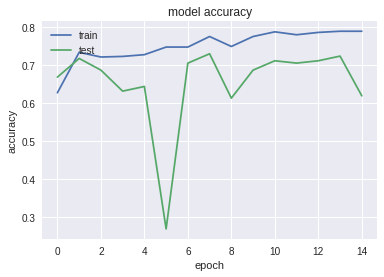

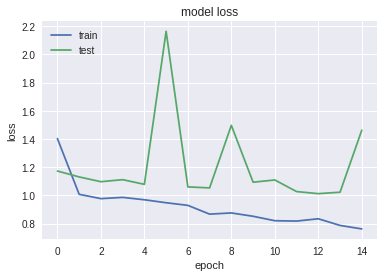

In [75]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [77]:
score = model.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

203/203 [==============================] - 2s 11ms/step
Test score: 0.9348955747529204
Test accuracy: 0.7389162573321112


In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [80]:
print(y_test_1d)
print(y_pred_1d)

[4, 1, 3, 3, 4, 3, 4, 4, 5, 0, 2, 5, 1, 4, 0, 4, 0, 2, 0, 4, 2, 2, 3, 3, 1, 0, 4, 3, 3, 5, 0, 0, 3, 5, 0, 2, 4, 5, 3, 5, 2, 5, 0, 5, 0, 1, 4, 0, 5, 0, 1, 5, 5, 0, 5, 5, 4, 4, 5, 5, 3, 3, 0, 0, 4, 3, 4, 2, 5, 4, 0, 0, 0, 5, 4, 5, 0, 4, 3, 3, 3, 1, 0, 5, 4, 5, 5, 4, 5, 5, 2, 3, 3, 5, 3, 3, 3, 5, 4, 5, 2, 4, 5, 5, 5, 0, 3, 5, 3, 5, 4, 1, 3, 1, 4, 1, 5, 0, 5, 2, 5, 4, 1, 5, 5, 5, 0, 0, 2, 4, 1, 4, 3, 4, 5, 2, 2, 4, 4, 0, 0, 4, 5, 3, 1, 3, 3, 3, 5, 5, 4, 5, 4, 3, 2, 4, 5, 2, 4, 3, 0, 5, 0, 2, 4, 5, 3, 5, 3, 0, 0, 5, 5, 5, 0, 2, 4, 5, 3, 5, 3, 5, 1, 5, 5, 3, 0, 4, 1, 5, 5, 5, 2, 0, 5, 0, 0, 5, 5, 3, 1, 1, 0]
[4, 0, 3, 3, 4, 3, 4, 4, 5, 0, 0, 5, 0, 4, 2, 4, 0, 0, 4, 4, 4, 0, 3, 3, 1, 0, 4, 3, 3, 5, 0, 0, 3, 5, 2, 0, 4, 5, 3, 5, 0, 5, 0, 5, 2, 0, 0, 0, 5, 0, 0, 5, 5, 2, 5, 5, 4, 4, 5, 5, 3, 0, 1, 0, 0, 3, 4, 4, 5, 0, 1, 0, 0, 5, 4, 5, 0, 4, 0, 3, 3, 0, 0, 5, 4, 5, 5, 4, 5, 5, 2, 3, 3, 5, 3, 3, 0, 5, 4, 5, 0, 4, 5, 5, 5, 0, 3, 5, 0, 0, 4, 0, 0, 0, 4, 1, 5, 0, 5, 0, 5, 4, 5, 5, 5, 5, 0, 0, 0, 0,

## Prepare Labels and Specs for the model
In this part of the notebook, we will create three list. One contains the specs and the other two the labels for paths and for specs. The lists are later used as input for the actual preprocessing and then later the model.

In [24]:
labelsPath = list()
labelsStruct = list()


for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])
  
print(str(len(labelsPath)))
print(str(len(labelsStruct)))

#labelsStruct = labelsS["cluster"].tolist()

1016
1016


In [25]:
print(labelsPath)
print(labelsStruct)

[1, 2, 3, 4, 5, 6, 7, 4, 4, 8, 3, 6, 8, 3, 4, 8, 6, 2, 4, 4, 2, 8, 6, 3, 4, 4, 8, 4, 9, 4, 4, 3, 3, 3, 4, 4, 6, 4, 8, 3, 9, 4, 4, 3, 3, 4, 3, 3, 3, 10, 4, 3, 3, 3, 8, 3, 3, 3, 4, 6, 1, 8, 4, 8, 6, 4, 6, 3, 3, 2, 6, 2, 3, 6, 9, 9, 4, 5, 1, 4, 8, 3, 4, 3, 6, 3, 3, 5, 4, 8, 8, 8, 9, 9, 8, 1, 4, 8, 3, 6, 4, 3, 3, 2, 9, 6, 6, 3, 8, 2, 3, 4, 5, 1, 6, 3, 8, 8, 6, 4, 8, 8, 4, 3, 4, 6, 4, 6, 2, 8, 4, 3, 9, 1, 6, 6, 3, 3, 4, 2, 3, 2, 6, 6, 4, 7, 1, 7, 7, 1, 7, 7, 7, 7, 7, 5, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 2, 7, 7, 2, 7, 7, 7, 2, 3, 5, 1, 8, 3, 9, 2, 4, 9, 2, 8, 9, 4, 9, 9, 9, 8, 2, 9, 2, 9, 9, 1, 2, 9, 8, 9, 5, 2, 2, 7, 4, 2, 2, 9, 7, 5, 5, 9, 9, 5, 5, 9, 9, 7, 9, 8, 7, 2, 8, 2, 9, 9, 5, 9, 9, 9, 2, 5, 5, 2, 5, 7, 2, 8, 9, 5, 1, 1, 9, 5, 9, 9, 5, 7, 1, 1, 1, 1, 1, 9, 5, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 7, 5, 5, 9, 4, 8, 9, 4, 2, 2, 4, 4, 6, 1, 5, 1, 3, 9, 8, 5, 7, 7, 9, 9, 8, 9, 7, 9, 4, 3, 9, 3, 4, 3, 2, 8, 5, 4, 8, 6, 2, 9, 4, 4, 5, 5, 7, 9,

### Create training and test split of the labels

In [0]:
Y_Path_train = labelsPath[:808]
Y_Path_test = labelsPath[808:]

Y_Struct_train = labelsStruct[:808]
Y_Struct_test = labelsStruct[808:]

In [0]:
print(len(Y_Path_train))
print(len(Y_Path_test))
print(len(Y_Struct_train))
print(len(Y_Struct_test))

In [0]:
with open('pickle/Y_Path_train.pickle', 'wb') as handle:
    pickle.dump(Y_Path_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Path_test.pickle', 'wb') as handle:
    pickle.dump(Y_Path_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_train.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_test.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
specs_json = list()

In [0]:
import json

In [0]:
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  specs_json.append(strJson)

print(str(len(specs_json)))
  
  

In [0]:
specs_json[1]

In [0]:
X_train = specs_json[:808]
X_test = specs_json[808:]

print(len(X_train))
print(len(X_test))

## Preprocessing
In this part of the notebook we are going to preprocess the data itself. The data will be tokenized, preprocessed and stored as Training and Test sets

In [0]:
from keras.preprocessing.text import Tokenizer

Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

*   word_counts: A dictionary of words and their counts.
*   word_docs: A dictionary of words and how many documents each appeared in.
*   word_index: A dictionary of words and their uniquely assigned integers.
*   document_count:An integer count of the total number of documents that were used to fit the Tokenizer.


[source](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)


In [0]:
tokenizer = Tokenizer(num_words=10000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')

tokenizer

tokenizer.fit_on_texts(specs_json)



x_train = tokenizer.texts_to_matrix(X_train)
x_test = tokenizer.texts_to_matrix(X_test)

--------------------------------

In [0]:
x_train

In [0]:
x_test

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsStruct)
y_train = encoder.transform(Y_Struct_train)
y_test = encoder.transform(Y_Struct_test)

In [0]:
y_train

In [0]:
len(x_train[0])

In [0]:
print('y_train shape:', y_train.shape)

In [0]:
print('x_train shape:', x_train.shape)

In [0]:
batch_size = 32
epochs = 2

---------------------------------------------------------------

## Model Architecture
In this section of the notebook the actual deep learning model is designed and the architecture presented before the actual training of it will take place.

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=10000))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax',name = 'softmax_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
print(model.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=3,
                    verbose=1,
                    validation_split=0.2)

In [0]:
model2 = Sequential()
model2.add(Dense(512, input_shape=(10000,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dense(6))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
print(model2.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model2.png')

In [0]:
history2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2)

### first training

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)


In [0]:
loss_and_metrics = model2.evaluate(x_test, y_test, batch_size=128)


### Use Model

In [0]:
classes = model.predict(x_test, batch_size=128)


In [0]:
classes2 = model2.predict(x_test, batch_size=128)

### Evaluation

In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()